In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
users = pd.read_csv("/content/users.csv")
transactions = pd.read_csv("/content/transactions.csv")
fraud = pd.read_csv("/content/fraud_flags.csv")


In [52]:
users.info()
transactions.info()
fraud.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           2000 non-null   object
 1   age               2000 non-null   int64 
 2   gender            2000 non-null   object
 3   city              2000 non-null   object
 4   state             2000 non-null   object
 5   signup_date       2000 non-null   object
 6   kyc_status        2000 non-null   object
 7   customer_segment  2000 non-null   object
dtypes: int64(1), object(7)
memory usage: 125.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transaction_id        50000 non-null  object 
 1   user_id               50000 non-null  object 
 2   transaction_datetime  50000 non-null  object 
 3   amount       

In [53]:
df = transactions.merge(fraud, on="transaction_id", how="left") \
                 .merge(users, on="user_id", how="left")


In [54]:
df.shape


(50000, 26)

In [55]:
df.isnull().sum()


,0
transaction_id,0
user_id,0
transaction_datetime,0
amount,0
currency,0
payment_method,0
transaction_status,0
merchant_id,0
merchant_category,0
device_type,1559


In [56]:
df["bank_name"].fillna("Unknown", inplace=True)
df["device_type"].fillna("Unknown", inplace=True)


/tmp/ipython-input-1177621034.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bank_name"].fillna("Unknown", inplace=True)
/tmp/ipython-input-1177621034.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [57]:
df["transaction_datetime"] = pd.to_datetime(
    df["transaction_datetime"],
    errors="coerce"
)

df["hour"] = df["transaction_datetime"].dt.hour
df["day"] = df["transaction_datetime"].dt.day_name()


In [58]:
df["transaction_status"].value_counts(normalize=True) * 100


,proportion
transaction_status,
Success,86.870
Failed,10.056
Pending,3.074


In [59]:
fraud_by_payment = df.groupby("payment_method")["is_fraud"].mean() * 100
fraud_by_payment.sort_values(ascending=False)


,is_fraud
payment_method,
Debit Card,5.595107
Net Banking,5.513557
Credit Card,5.473089
Wallet,5.383700
UPI,5.288129


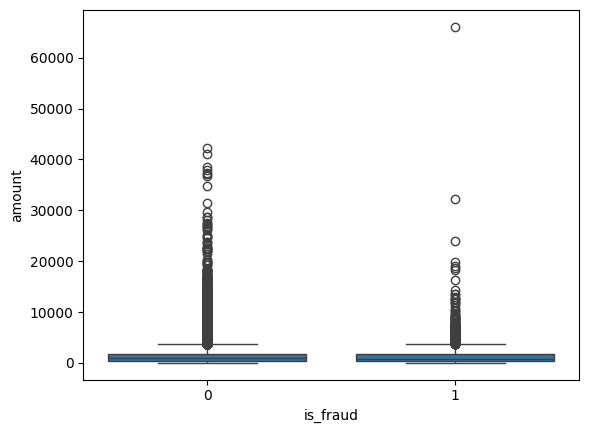

In [60]:
sns.boxplot(x="is_fraud", y="amount", data=df)
plt.show()


In [61]:
df["risk_level"] = pd.cut(
    df["fraud_risk_score"],
    bins=[0, 0.4, 0.7, 1],
    labels=["Low", "Medium", "High"]
)

df["risk_level"].value_counts()


,count
risk_level,
Low,19191
High,16332
Medium,14233


In [62]:
ml_df = df[
    [
        "amount",
        "payment_method",
        "device_type",
        "city_x",
        "state_x",
        "is_international",
        "hour",
        "customer_segment",
        "kyc_status",
        "is_fraud"
    ]
].copy()

ml_df.head()


,amount,payment_method,device_type,city_x,state_x,is_international,hour,customer_segment,kyc_status,is_fraud
0,4868.42,Credit Card,Android,Bengaluru,RJ,0,13.0,Retail,Verified,0
1,563.44,Wallet,iOS,Kolkata,RJ,0,NaN,Retail,Verified,0
2,927.80,Wallet,iOS,Kolkata,MH,0,2.0,Retail,Verified,0
3,1349.54,Wallet,iOS,Ahmedabad,TG,0,NaN,Retail,Verified,0
4,407.92,Net Banking,Android,Pune,RJ,0,11.0,Retail,Verified,0


In [63]:
ml_df.fillna("Unknown", inplace=True)


/tmp/ipython-input-948935312.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ml_df.fillna("Unknown", inplace=True)


In [64]:
ml_df_encoded = pd.get_dummies(
    ml_df,
    columns=[
        "payment_method",
        "device_type",
        "city_x",
        "state_x",
        "customer_segment",
        "kyc_status"
    ],
    drop_first=True
)



In [65]:
ml_df.dtypes


,0
amount,float64
payment_method,object
device_type,object
city_x,object
state_x,object
is_international,int64
hour,object
customer_segment,object
kyc_status,object
is_fraud,int64


In [66]:
categorical_cols = ml_df.select_dtypes(include=["object"]).columns
categorical_cols


Index(['payment_method', 'device_type', 'city_x', 'state_x', 'hour',
       'customer_segment', 'kyc_status'],
      dtype='object')

In [67]:
ml_df_encoded = pd.get_dummies(
    ml_df,
    columns=categorical_cols,
    drop_first=True
)


In [68]:
from sklearn.model_selection import train_test_split

X = ml_df_encoded.drop("is_fraud", axis=1)
y = ml_df_encoded["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


In [70]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


[[11819     0]
 [  139   542]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11819
           1       1.00      0.80      0.89       681

    accuracy                           0.99     12500
   macro avg       0.99      0.90      0.94     12500
weighted avg       0.99      0.99      0.99     12500

